In [1]:
import sys
sys.path.insert(0,'/home/lshtanko/Programming/another-fem-framework/')
#sys.path.insert(0,'/Users/marusy/Programming/another-fem-framework/')
#sys.path.insert(0,'/Users/leonshting/Programming/Schlumberger/fem-framework/')

In [2]:
from operator_assembler.assembly_interface import AssemblyInterface2D
from operator_assembler.n_to_1_ddof_allocator import Nto1Allocator2D
from grid.grid_manager import GridManager
from grid.allocator_interface import InterfaceDofAllocator2D
from grid.grid_domain import GridDomain
from operator_assembler.matrix_assembler import MatrixAssembler2D
from scipy.ndimage import imread
from grid import cell, grid_layer, grid_manager
import h5py
import numpy as np

from interpolant.cell_to_points import *
from common import visual
from common.tests import *
from common.helpers import *
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix, dok_matrix, coo_matrix
from scipy.sparse import linalg

%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 10

In [3]:
np.set_printoptions(linewidth=500)

#### Bad cell

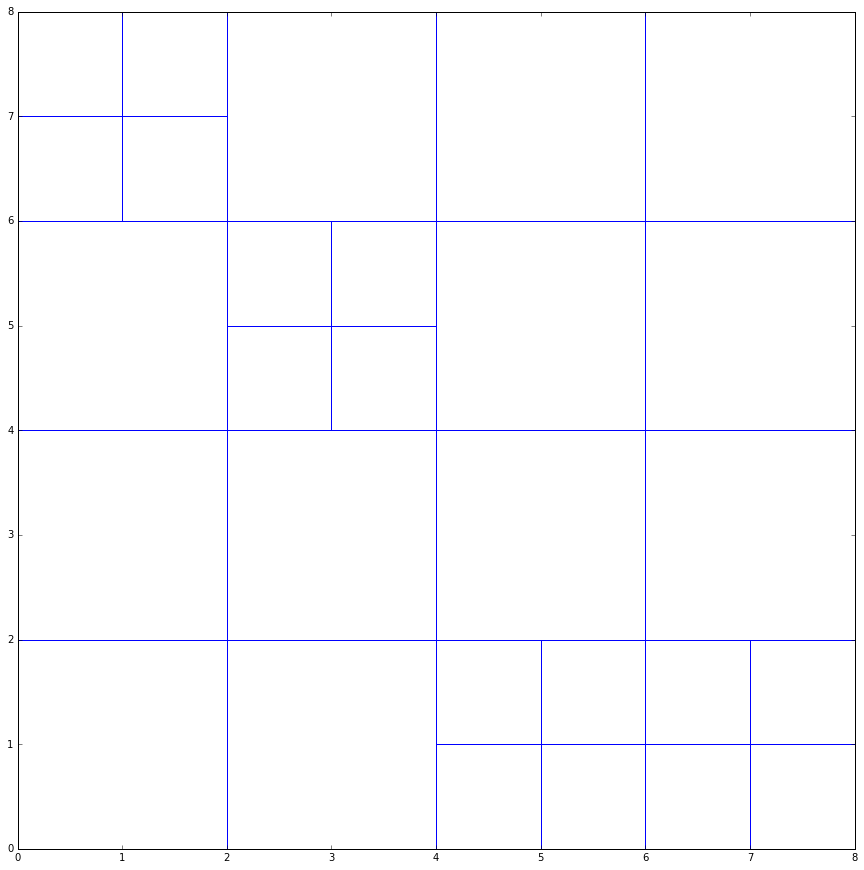

In [4]:
data_start = (133, 28)
data_shape = (8, 8)
data_end = tuple([i+j for i,j in zip(data_start, data_shape)])

h5_data = h5py.File('../../../GM_L3D/600/state/viz_GM_1.h5')['index'][0]
data = h5_data[data_start[0]:data_end[0], data_start[1]:data_end[1]]
#data = imread('/Users/marusy/Programming/model/bhi2_labelled0000.tif')[data_start[0]:data_end[0], data_start[1]:data_end[1]]

grid_domain = GridDomain(integer_size=data_shape, domain_size=(1.,1.))
gm = GridManager()
ifma = InterfaceDofAllocator2D(grid_manager=gm.fit(data=data))


gm.draw_grid()

In [ ]:
grid_domain.normal_index[28]

In [ ]:
cell15 = cell.Cell2D(size=(1,1), ll_vertex=(0,8))
cell25 = cell.Cell2D(size=(1,1), ll_vertex=(0,9))

cell14 = cell.Cell2D(size=(1,1), ll_vertex=(0,6))
cell24 = cell.Cell2D(size=(1,1), ll_vertex=(0,7))

cell13 = cell.Cell2D(size=(1,1), ll_vertex=(0,4))
cell23 = cell.Cell2D(size=(1,1), ll_vertex=(0,5))

cell12 = cell.Cell2D(size=(1,1), ll_vertex=(0,2))
cell22 = cell.Cell2D(size=(1,1), ll_vertex=(0,3))

cell1 = cell.Cell2D(size=(1,1), ll_vertex=(0,0))
cell2 = cell.Cell2D(size=(1,1), ll_vertex=(0,1))

cell3 = cell.Cell2D(size=(2,2), ll_vertex=(1,0))
cell32 = cell.Cell2D(size=(2,2), ll_vertex=(1,2))
cell33 = cell.Cell2D(size=(2,2), ll_vertex=(1,4))
cell34 = cell.Cell2D(size=(2,2), ll_vertex=(1,6))
cell35 = cell.Cell2D(size=(2,2), ll_vertex=(1,8))

In [ ]:
layer1 = grid_layer.GridLayer2D([c.ll_vertex for c in [cell1, cell2, cell12, cell22, cell13, cell23, cell14, cell24, cell15, cell25]], layer_number=0, index=[1,1], div_index=[1,1])
layer2 = grid_layer.GridLayer2D([c.ll_vertex for c in [cell3, cell32, cell33, cell34, cell35]], layer_number=1, index=[1], div_index=[1])

#layer1 = grid_layer.GridLayer2D([c.ll_vertex for c in [cell1, cell2]], layer_number=0, index=[1,1], div_index=[1,1])
#layer2 = grid_layer.GridLayer2D([c.ll_vertex for c in [cell3]], layer_number=1, index=[1], div_index=[1])

In [ ]:
gm = grid_manager.GridManager(dim=2, method='coarse2to1')
gm.grid_layers = [layer1, layer2]
ifma = InterfaceDofAllocator2D(grid_manager=gm)

## setting the order of BF
#ifma._default_order = 3

In [5]:
ma = Nto1Allocator2D(grid_interface=ifma)
ma._make_ddof_index()

In [ ]:
#6 cells
ma._vertex_ddof_index[((0, 3), (0, 4))] = (ma._vertex_ddof_index[((0, 3), (0, 4))][0], ma._vertex_ddof_index[((0, 0), (0, 0))][1])
ma._vertex_ddof_index[((0, 3), (1, 4))] = (ma._vertex_ddof_index[((0, 3), (1, 4))][0], ma._vertex_ddof_index[((0, 0), (1, 0))][1])
ma._vertex_ddof_index[((1, 2), (1, 4))] = (ma._vertex_ddof_index[((1, 2), (1, 4))][0], ma._vertex_ddof_index[((1, 0), (1, 0))][1])
ma._vertex_ddof_index[((1, 2), (3, 4))] = (ma._vertex_ddof_index[((1, 2), (3, 4))][0], ma._vertex_ddof_index[((1, 0), (3, 0))][1])

In [ ]:
#3 cells
ma._vertex_ddof_index[((0, 1), (0, 2))] = (ma._vertex_ddof_index[((0, 1), (0, 2))][0], ma._vertex_ddof_index[((0, 0), (0, 0))][1])
ma._vertex_ddof_index[((0, 1), (1, 2))] = (ma._vertex_ddof_index[((0, 1), (1, 2))][0], ma._vertex_ddof_index[((0, 0), (1, 0))][1])
ma._vertex_ddof_index[((1, 0), (1, 2))] = (ma._vertex_ddof_index[((1, 0), (1, 2))][0], ma._vertex_ddof_index[((1, 0), (1, 0))][1])
ma._vertex_ddof_index[((1, 0), (3, 2))] = (ma._vertex_ddof_index[((1, 0), (3, 2))][0], ma._vertex_ddof_index[((1, 0), (3, 0))][1])

In [ ]:
#6 cells
edge_mapping = {((0, 4), (1, 4)): ((0, 0), (1, 0)), ((1, 4), (3, 4)): ((1, 0), (3, 0))}
#3cells
#edge_mapping = {((0, 2), (1, 2)): ((0, 0), (1, 0)), ((1, 2), (3, 2)): ((1, 0), (3, 0))}
for (cell, edge), dd in ma._edge_ddof_index.items():
    if edge_mapping.get(edge) is not None:
        edge_slave = edge
        edge_prim = edge_mapping[edge]
        prim_cell = [i for i in list(ma._edge_ddof_index.keys()) if i[1] == edge_prim][0][0]
        ma._edge_ddof_index[(cell, edge_slave)] = [(i[0],j[1])
            for i,j in
            zip(ma._edge_ddof_index[(cell, edge_slave)], ma._edge_ddof_index[(prim_cell, edge_prim)])
        ]

In [ ]:
#6 cells
ma._weak_edge_connections[ ((0, 2),
  ((1, 2), (1, 3)))] = {((1, 2), ((1, 2), (1, 4))): [(0, 54),
   (1, 74),
   (2, 75),
   (3, 61)]}

ma._weak_edge_connections[((0, 3),
  ((1, 3), (1, 4)))] = {((1, 2), ((1, 2), (1, 4))): [(0, 54),
   (1, 74),
   (2, 75),
   (3, 61)]}

ma._weak_edge_connections[((1, 2),
  ((1, 2), (1, 4)))] = {((0, 2), ((1, 2), (1, 3))): [(12, 19),
   (13, 34),
   (14, 35),
   (15, 31)], ((0, 3), ((1, 3), (1, 4))): [(12, 31),
   (13, 46),
   (14, 47),
   (15, 9)]}

In [ ]:
#3cells
ma._weak_edge_connections[((0, 0), ((1, 0), (1, 1)))] = {((1, 0), ((1, 0), (1, 2))): [(0, 37),
   (1, 38),
   (2, 39),
   (3, 37)]}
ma._weak_edge_connections[((0, 1), ((1, 1), (1, 2)))] = {((1, 0), ((1, 0), (1, 2))): [(0, 37),
   (1, 38),
   (2, 39),
   (3, 37)]}

ma._weak_edge_connections[((1, 0),((1, 0), (1, 2)))] = {((0, 0), ((1, 0), (1, 1))): [(12, 9),
   (13, 10),
   (14, 11),
   (15, 3)], ((0, 1), ((1, 1), (1, 2))): [(12, 3),
   (13, 22),
   (14, 23),
   (15, 9)]}

In [6]:
grid_domain = GridDomain(domain_size=(8.,8.), integer_size=(8,8))
grid_domain.make_pointwise_index(ma)

In [7]:
ifma2 = AssemblyInterface2D(allocator=ma)
MA = MatrixAssembler2D(assembly_interface=ifma2, grid_domain=grid_domain)

In [8]:
MA.assemble_dist()

In [9]:
MA.assemble_glob_local()

In [10]:
new = MA.unmerged * MA.dist
new_ass = MA.dist.T * MA.unmerged * MA.dist

In [11]:
new_alt = MA.unmerged * MA.dist_alt
new_ass_alt = MA.dist_alt.T * MA.unmerged * MA.dist_alt

In [ ]:
plt.imshow(new_ass.toarray() - new_ass_alt.toarray(), interpolation='none')

In [ ]:
plt.imshow(new_ass_alt.toarray(), interpolation='none')

In [ ]:
deep = MA.assemble()

In [ ]:
sine_test = grid_domain.vectorize_function(lambda x,y: np.sin(x+y))
product = grid_domain.devectorize_vector(new_ass * sine_test)
init = grid_domain.devectorize_function(lambda x,y: np.sin(x+y))

visual.plot_surface_unstructured_w_dict(
    point_val_dict=grid_domain.devectorize_vector(new_ass * sine_test),
    plot_domain_shape=grid_domain.domain_size,
    int_domain_shape=grid_domain.integer_size
)

#visual.plot_surface_unstructured_w_dict(
#    point_val_dict=grid_domain.devectorize_function(lambda x,y: np.sin(x+y)),
#    plot_domain_shape=grid_domain.domain_size,
#    int_domain_shape=grid_domain.integer_size
#)

In [ ]:
for i in [37]:
    print(i, end=' ')
    partial_diff_test(matrix=new_ass_alt,
                      point=grid_domain.normal_index[i],
                      pointnum=i,
                      pointdict=grid_domain.pointwise_index)

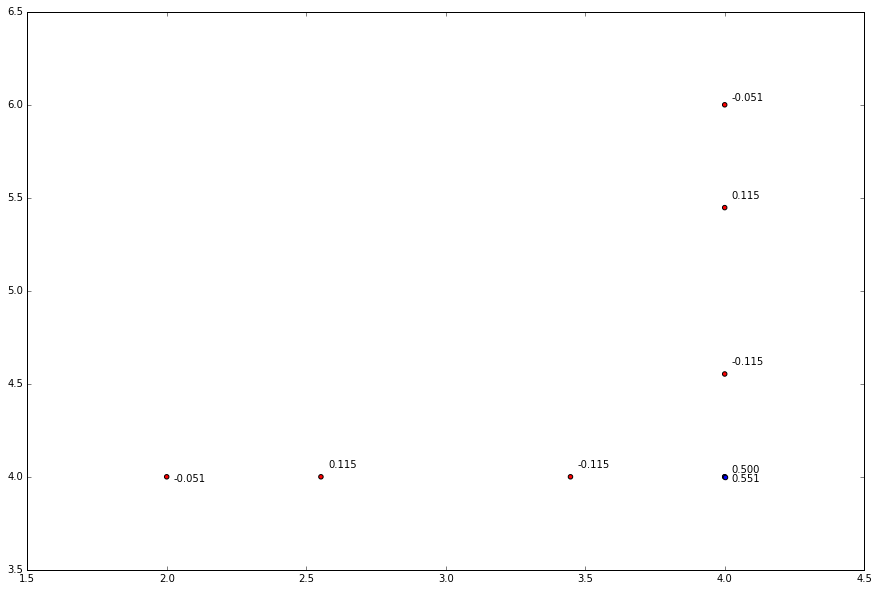

In [13]:
for num,i in enumerate([37]):
    visual.deps_partial_diff(
        matrix=MA.dist_alt,
        pointnum=i, num2point_index=grid_domain.normal_index,
        print_text=True,
        p2n_index = grid_domain.pointwise_index
    )


In [ ]:
for num,i in enumerate([259]):
    visual.deps_partial_diff(
        matrix=MA.unmerged,
        pointnum=i, num2point_index=grid_domain.normal_index,
        print_text=True,
        p2n_index = grid_domain.pointwise_index
    )


In [ ]:
np.argsort(np.array(MA.dist.sum(axis=1)).flatten())

In [ ]:
plt.imshow(MA.dist.toarray())